In [1]:
import torch
from torchvision.models import resnet50
import torchvision

/kuacc/users/oince22/.conda/envs/fromage_scratch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'health_multimodal'

In [ ]:
# Courtesy to Görkem Mahir Eriş from Kaggle -> https://www.kaggle.com/code/grkemeri/over-98-validation-accuracy-with-using-pytorch

%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

print('Pytorch version  ', torch.__version__)

In [10]:
root_dir = "COVID-19 Radiography Database"
source_dirs= ["Normal", "Viral Pnemuonia", "COVID"]

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [11]:
from health_multimodal.image.data.transforms import create_chest_xray_transform_for_inference

transform_center_crop_size = 480
TRANSFORM_RESIZE = 512

train_transform = create_chest_xray_transform_for_inference(resize=TRANSFORM_RESIZE, center_crop_size=transform_center_crop_size)
test_transform = create_chest_xray_transform_for_inference(resize=TRANSFORM_RESIZE, center_crop_size=transform_center_crop_size)

In [14]:
import pydicom
import cv2

def convert_dicom_to_jpeg(dicom_path, jpeg_path, resize=False, new_width=512):
    # Load DICOM file
    dicom = pydicom.dcmread(dicom_path)

    # Extract pixel data and metadata
    pixels = dicom.pixel_array
    photometric_interpretation = dicom.get("PhotometricInterpretation", "")

    # Normalize pixel values to range [0, 255]
    if photometric_interpretation.startswith("MONOCHROME"):
        # Determine the minimum and maximum pixel values
        min_pixel_value = pixels.min()
        max_pixel_value = pixels.max()

        # Normalize pixel values to range [0, 255]
        pixels = ((pixels - min_pixel_value) / (max_pixel_value - min_pixel_value)) * 255

        # Invert pixel values if necessary
        if photometric_interpretation.endswith("1"):
            pixels = 255 - pixels

    # Convert pixel data to 8-bit unsigned integer
    pixels = pixels.astype('uint8')
    
    if resize:
        # Write the image as JPEG file
        height, width = pixels.shape

        # Calculate the scaling factor to maintain the aspect ratio
        scale = new_width / width
        new_height = int(height * scale)

        # Resize the image using the calculated dimensions
        pixels = cv2.resize(pixels, (new_width, new_height))


    # Apply histogram equalization
    pixels = cv2.equalizeHist(pixels)
    
    return pixels

(615, 512)
<PIL.Image.Image image mode=RGB size=512x615 at 0x2B10B7D06A10>


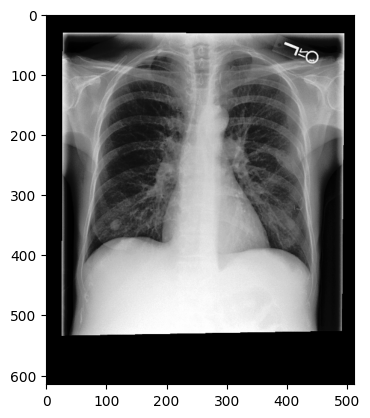

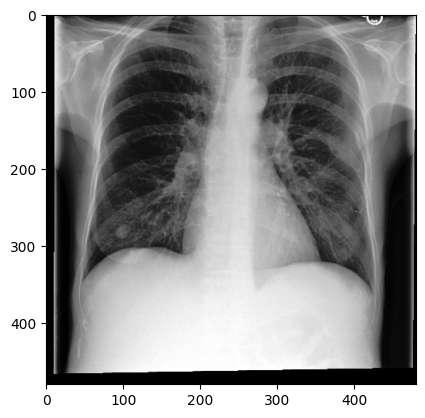

In [41]:
dicom_path = "/datasets/mimic/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm"
jpeg_path = "test2_resized.jpg"
img = convert_dicom_to_jpeg(dicom_path, jpeg_path, resize=True)
print(img.shape)
#img = np.tile(img, (3, 1, 1)).reshape(*img.shape, 3)
#print(img.shape)
img = Image.fromarray(img).convert("RGB")
print(img)
plt.imshow(img, cmap="gray")
plt.figure()
img = test_transform(img)
img = img.permute(1, 2, 0).numpy()
img = img * 255
img = img.astype(np.uint8)
img = Image.fromarray(img)
plt.imshow(img)

In [12]:
train_dirs = {
    "normal" : "COVID-19_Radiography_Dataset/Normal/images",
    "viral" : "COVID-19_Radiography_Dataset/Viral Pneumonia/images",
    "covid" : "COVID-19_Radiography_Dataset/COVID/images"
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)
training_data_size = 0.8

train_size = int(training_data_size * len(train_dataset))
test_size = len(train_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

print("Length of train set   :  ", len(train_dataset))
print("Length of test set    :  ", len(test_dataset))

FileNotFoundError: [Errno 2] No such file or directory: 'COVID-19_Radiography_Dataset/Normal/images'

In [13]:
batch_size = 24

data_train_len = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
data_test_len = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print("Length of training batches", len(data_train_len))
print("Lentgth of test batches", len(data_test_len))

NameError: name 'train_dataset' is not defined

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.biovil_model = get_biovil_image_encoder()
        self.fc1 = torch.nn.Linear(2048, 128)
        self.fc2 = torch.nn.Linear(128, 3)
        self.relu = torch.nn.ReLU()
        
    def freeze_backbone(self):
        self.biovil_model.requires_grad = False
        
    def forward(self, x):
        x = self.biovil_model(x)
        print(x.__dict__.keys())
        print(f"x.img_embedding.shape: {x.img_embedding.shape}")
        print(f"x.patch_embeddings.shape: {x.patch_embeddings.shape}")
        print(f"x.projected_global_embedding.shape: {x.projected_global_embedding.shape}")
        print(f"x.projected_patch_embeddings.shape: {x.projected_patch_embeddings.shape}")
        x = x.img_embedding
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
import gc
loss_fn = torch.nn.CrossEntropyLoss()
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
device

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase
        model.biovil_model.eval()
        

        for train_step, (images, labels) in enumerate(data_test_len):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 50 == 19:
                print('Evaluating at step', train_step)

                accuracy = 0

                model.eval() # set model to eval phase

                with torch.no_grad():
                    for val_step, (images, labels) in enumerate(data_test_len):
                        images = images.to(device)
                        labels = labels.to(device)

                        outputs = model(images)
                        loss = loss_fn(outputs, labels)
                        val_loss += loss.item()

                        outputs = outputs.detach().cpu()
                        labels = labels.detach().cpu()

                        _, preds = torch.max(outputs, 1)
                        accuracy += sum((preds == labels).numpy())
                        print(f"Val step: {val_step}", end="\r")

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                model.train()
                model.biovil_model.eval()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
class_names = ["normal x-ray", "viral x-ray","covid positive"]

def show_images(images,labels,preds):
    plt.figure(figsize=(15,7))
    for i , image in enumerate(images):
        plt.subplot(1,11,i+1, xticks = [], yticks= [])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.5, 0.5, 0.4])
        std = np.array([0.2, 0.2, 2])
        image = image*std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        colorr = "green"
        if(preds[i] != labels[i]):
            
            colorr="red"
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colorr)
    plt.tight_layout()
    plt.show()

def test_predicts():
    model.eval()
    images, labels = next(iter(data_test_len))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    outputs = outputs.detach().cpu()
    labels = labels.detach().cpu()
    _, preds = torch.max(outputs, 1)
    images = images.detach().cpu()
    show_images(images, labels, preds)

In [ ]:
train(epochs = 4)

In [ ]:
test_predicts()

In [ ]:
"""
import torch
from torchvision.models import resnet50
model = resnet50()
base_keys = list(model.state_dict().keys())
model_state_dict = torch.load('biovil_image_resnet50_proj_size_128.pt')
keys = list(model_state_dict.keys())
for k in keys:
    if "encoder.encoder" in k:
        new_key = ".".join(k.split(".")[2:])
        model_state_dict[new_key] = model_state_dict[k]
        del model_state_dict[k]
    else:
        del model_state_dict[k]
model_state_dict
sorted(base_keys) == sorted(list(model_state_dict.keys()))
model.load_state_dict(model_state_dict)
"""